In [17]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

#### Import data and labels

In [18]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'

# Load Data 
# with open(data_path+'/simulation_0.npy', 'rb') as a:    #'+str(sim_num)+'
#     data_in_0 = np.load(a)  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
# with open(data_path+'/simulation_25.npy', 'rb') as c:    #'+str(sim_num)+'
#     data_in_25 = np.load(c)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
    
# Load MC Truth
# with open(data_path+'/inner_ph_0.npy', 'rb') as e:      #'+str(sim_num)+'
#     ph_in_0 = np.load(e)
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
# with open(data_path+'/inner_ph_25.npy', 'rb') as g:      #'+str(sim_num)+'
#     ph_in_25 = np.load(g)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)

### Reshaping data_0

In [19]:
# d0 = data_in_0.reshape(-1, 31, 31 )
# new_data_0 = np.array(resize_with_crop_or_pad(d0.T.reshape(31,31,-1), 32, 32)).T
# new_data_0.shape

### Concatenating multiple datasets

In [20]:
###### fixed parameters ###########
n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
cam_side_length = 32
###################################

# inner_ph_in_0 = ph_in_0[:,0].reshape(n_cam_in_grain_0, -1)
inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)

# inner_ratio_0 = (ph_in_0[:,0]/ph_in_0[:,1]).reshape(n_cam_in_grain_0, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)

# new_data_0 = new_data_0.reshape(-1, cam_side_length**2)
data_in_1 = data_in_1.reshape(-1, cam_side_length**2)
data_in_2 = data_in_2.reshape(-1, cam_side_length**2)

data_in = np.concatenate((data_in_1, data_in_2)) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'))) #np.ravel(inner_ph_in_0, order='F'), 
inner_ratio = np.concatenate((np.ravel(inner_ratio_1, order='F'), np.ravel(inner_ratio_2, order='F'))) #np.ravel(inner_ratio_0, order='F'), 

inner_ratio[np.isnan(inner_ratio)] = 0
# data_in = data_in_1 #new_data_0
# inner_ph_in = np.ravel(inner_ph_in_1, order='F')


C:\Users\Pc\AppData\Local\Temp\ipykernel_14816\3615897009.py:13: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_14816\3615897009.py:14: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)


### Label data

labelled-blind cameras : 376


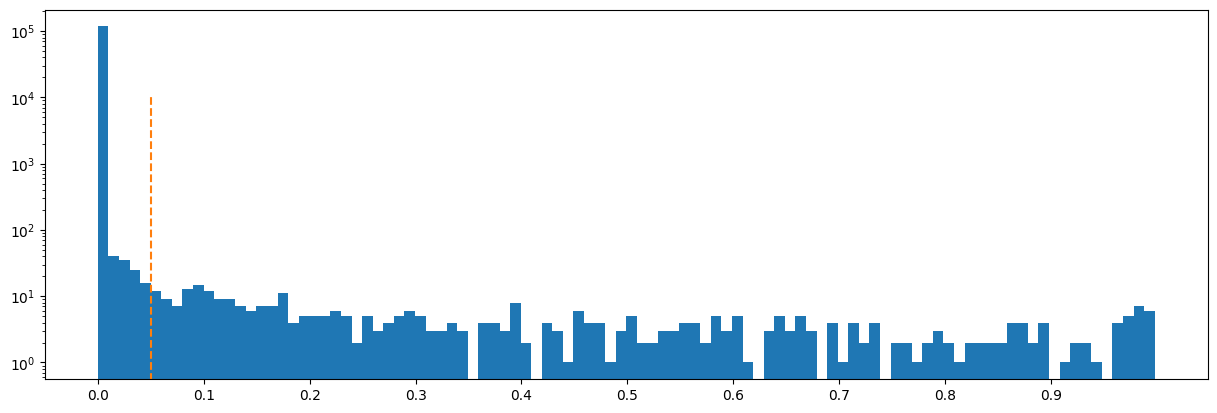

In [21]:
###### parameters #################
ph_threshold = 50                 #
ratio_threshold = 0.05            #
###################################

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_blind = label[label==1].shape[0]
n_not_blind = label[label==0].shape[0]
print('labelled-blind cameras :', n_blind)

# add pixel saturation
data_in[data_in > 1000] = 1000

fig = plt.figure()
plt.hist(inner_ratio, 100)
plt.yscale('log')
plt.xticks(np.arange(0, 1, 0.1))
plt.plot([ratio_threshold, ratio_threshold],[0,1e4], '--')
fig.set_figwidth(15)

C:\Users\Pc\AppData\Local\Temp\ipykernel_14816\4131098505.py:7: RuntimeWarning: invalid value encountered in divide
  _ratio = 1 - _mean/_max


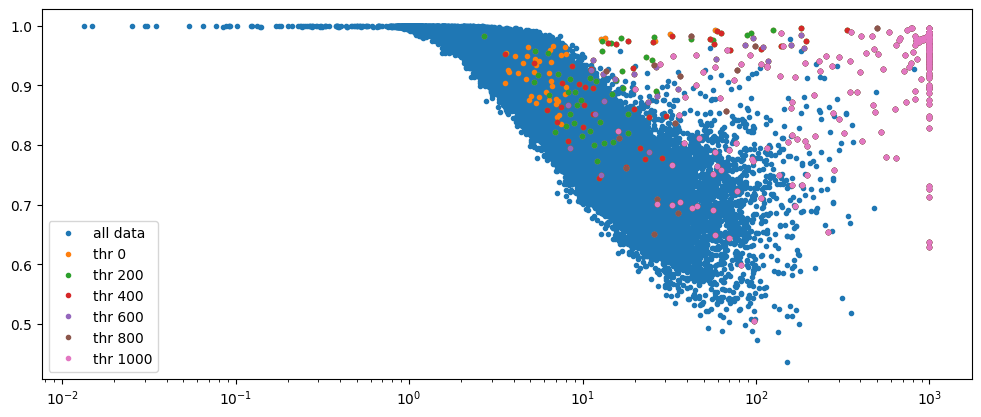

In [40]:
fig = plt.figure()

_amp = np.sum(data_in, axis=1)
_max = np.max(data_in, axis=1)
_mean = np.mean(data_in, axis=1)

_ratio = 1 - _mean/_max

_ratio[np.isnan(_ratio)] = 1

plt.plot(_max, _ratio, '.', label='all data')

for thr in range(0, 1200, 200):
    lab = np.zeros(inner_ph_in.shape[0])
    for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > thr) )[0]:
        lab[i] = 1
    plt.plot(_max[lab == 1], _ratio[lab == 1], '.', label='thr '+str(thr))
    
plt.xscale('log')
plt.legend()
fig.set_figwidth(12)

#### Split into test and training sets

In [ ]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = data_in[:sep], data_in[sep:] #normalize_data[:800], normalize_data[800:]
train_label, test_label = label[:sep], label[sep:]

print(train_data.shape)
print(train_label.shape)

(94400, 1024)
(94400,)


In [ ]:
train_blind = train_data[np.where(train_label==1)]
train_not_blind = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_blind))
artificial_train_blind = np.repeat(train_blind, int(0.3*n_not_blind/train_blind.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)
for r in range(artificial_train_blind.shape[0]) :
    artificial_train_blind[r] = np.roll(artificial_train_blind[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_blind.shape[0])

print('blind cameras - total data ratio:',(len(artificial_train_label) + len(train_label[train_label == 1]))/len(train_label))

blind cameras - total data ratio: 0.37457627118644066


In [ ]:
# train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
# test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

# train_data /= renormalisation
# test_data /= renormalisation

# train_label = train_label.flatten()
# test_label = test_label.flatten()

train_data = np.append(train_data, artificial_train_blind.reshape(-1, cam_side_length**2),axis=0)
train_label = np.append(train_label, artificial_train_label)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

#train_data = random.shuffle(train_data, 25)

# train_label_ohe = to_categorical(train_label,2)
# test_label_ohe = to_categorical(test_label,2)

# train_label_ohe.shape

### Feature Extraction

In [ ]:
train_amp = np.sum(train_data, axis=1)
test_amp = np.sum(test_data, axis=1)
train_max = np.max(train_data, axis=1)
test_max = np.max(test_data, axis=1)
train_mean = np.mean(train_data, axis=1)
test_mean = np.mean(test_data, axis=1)

test_ratio = 1 - test_mean/test_max
train_ratio = 1 - train_mean/train_max

test_ratio[np.isnan(test_ratio)] = 1
train_ratio[np.isnan(train_ratio)] = 1

train_arr = np.column_stack((train_ratio, train_max))
test_arr = np.column_stack((test_ratio, test_max))

C:\Users\Pc\AppData\Local\Temp\ipykernel_14816\4026788037.py:8: RuntimeWarning: invalid value encountered in divide
  test_ratio = 1 - test_mean/test_max
C:\Users\Pc\AppData\Local\Temp\ipykernel_14816\4026788037.py:9: RuntimeWarning: invalid value encountered in divide
  train_ratio = 1 - train_mean/train_max


### Plot data features

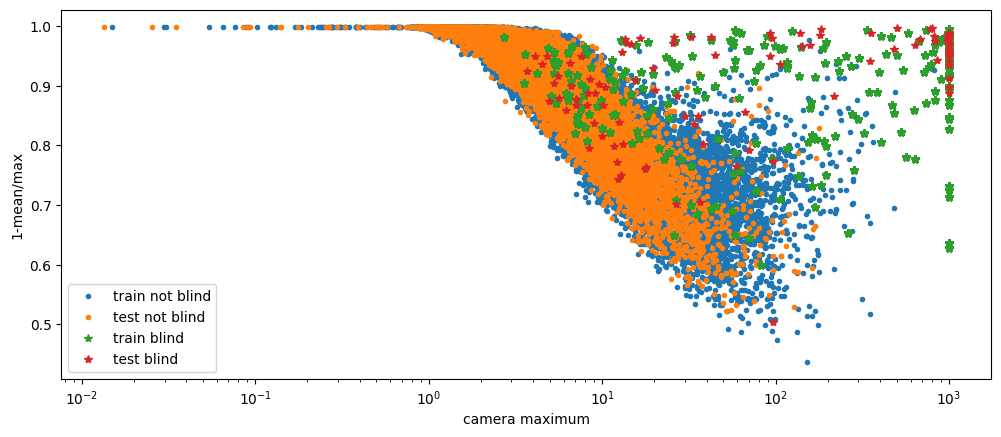

In [ ]:
# plt.plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
plt.figure().set_figwidth(12)
plt.plot(train_max[train_label == 0], train_ratio[train_label == 0], '.', label='train not blind')
plt.plot(test_max[test_label == 0], test_ratio[test_label == 0], '.', label='test not blind')
plt.plot(train_max[train_label == 1], train_ratio[train_label == 1], '*', label='train blind')
plt.plot(test_max[test_label == 1], test_ratio[test_label == 1], '*', label='test blind')

# ax[0].yscale('log')
plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()



### Build the model

In [ ]:
sgd_clf = SGDClassifier(max_iter=2000, tol=1e-3, random_state=42)
sgd_clf.fit(train_arr, train_label)

SGDClassifier(max_iter=2000, random_state=42)

In [ ]:
sgd_score = sgd_clf.score(test_arr, test_label)
cross_score = cross_val_score(sgd_clf, test_arr, test_label, cv=2, scoring="precision")
pred_label = cross_val_predict(sgd_clf, test_arr, test_label, cv=2)

cm = confusion_matrix(pred_label, test_label)
prec = precision_score(pred_label, test_label)
reca = recall_score(pred_label, test_label)
f1 = f1_score(pred_label, test_label)
    
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)

confusion matrix :
[[23484    60]
 [   12    44]]
precision : 0.4230769230769231
recall : 0.7857142857142857
f1 score : 0.55


In [ ]:
# kfold = KFold(n_splits=10, random_state=7, shuffle=True)
# LM = LinearRegression()
# # scoring = 'neg_mean_absolute_error'                                  # <---
# cross_score_LM = cross_val_score(LM, test_arr, test_label, cv=kfold, scoring='neg_mean_absolute_error')
# pred_label_LM = cross_val_predict(LM, test_arr, test_label, cv=kfold)

# cm_LM = confusion_matrix(pred_label_LM, test_label)
# prec_LM = precision_score(pred_label_LM, test_label)
# reca_LM = recall_score(pred_label_LM, test_label)
# f1_LM = f1_score(pred_label_LM, test_label)
    
# print('confusion matrix :')
# print(cm_LM)
# print('precision :', prec_LM)
# print('recall :', reca_LM)
# print('f1 score :', f1_LM)

## Prediction vs MC truth visualization

C:\Users\Pc\AppData\Local\Temp\ipykernel_23468\3017836776.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
C:\Users\Pc\AppData\Local\Temp\ipykernel_23468\3017836776.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this 

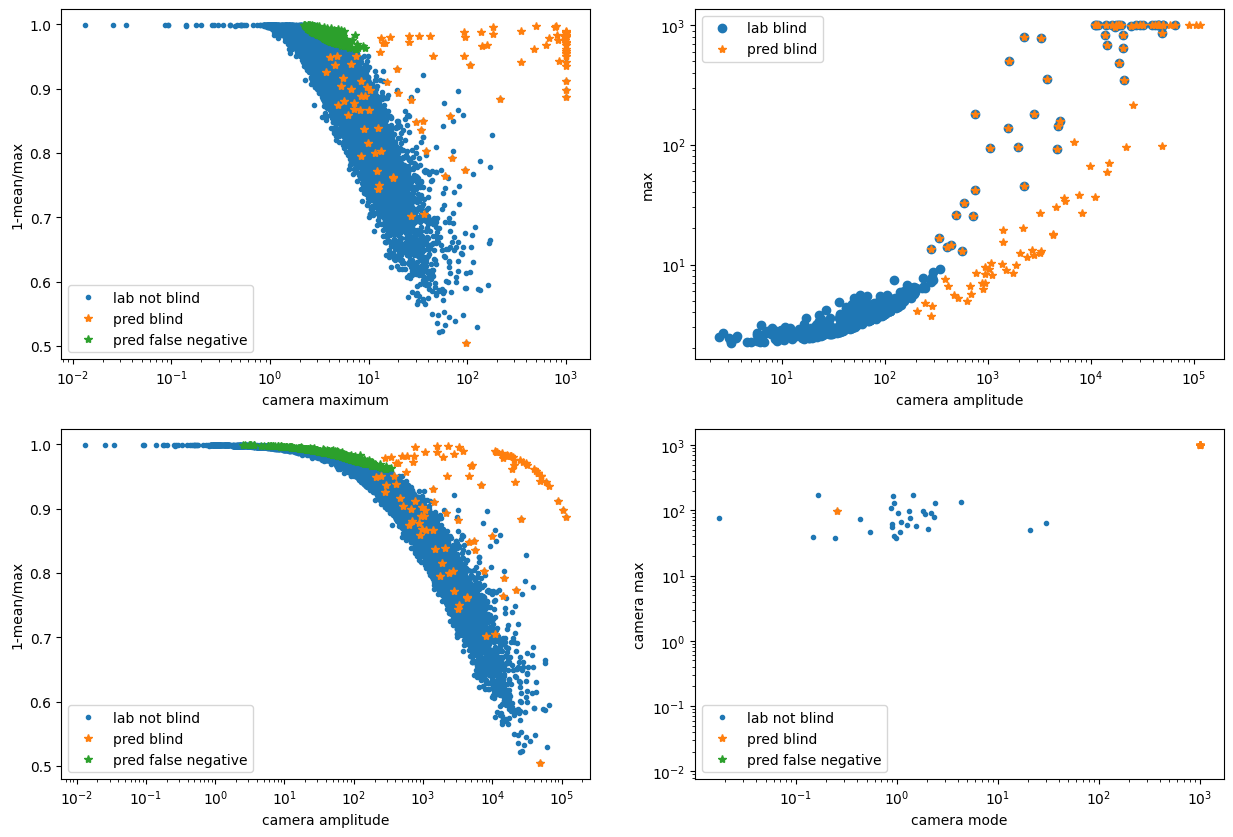

In [ ]:
test_d = data_in[sep:]
#test_d = MaxAbsScaler().fit_transform(data_in[sep:])

lab_bl = test_d[np.where(pred_label==1)]
lab_not_bl = test_d[np.where(pred_label==0)]
pred_bl = test_d[np.where(test_label==1)]
pred_not_bl = test_d[np.where(test_label==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_label==1), np.where(test_label==0))]

lab_not_bl_amp = np.sum(lab_not_bl, axis=1)
lab_bl_amp = np.sum(lab_bl, axis=1)
pred_bl_amp = np.sum(pred_bl, axis=1)
pred_not_bl_amp = np.sum(pred_not_bl, axis=1)
pred_fn_amp = np.sum(pred_fn, axis=1)
pred_bl_mod = stats.mode(pred_bl, axis=1)[0].ravel()
lab_not_bl_mod = stats.mode(lab_not_bl, axis=1)[0].ravel()
pred_fn_mod = stats.mode(pred_fn, axis=1)[0].ravel()

lab_not_bl_max = np.max(lab_not_bl, axis=1)
lab_bl_max = np.max(lab_bl, axis=1)
pred_bl_max = np.max(pred_bl, axis=1)
pred_not_bl_max = np.max(pred_not_bl, axis=1)
pred_fn_max = np.max(pred_fn, axis=1)

lab_not_bl_mean = np.mean(lab_not_bl, axis=1)
lab_bl_mean = np.mean(lab_bl, axis=1)
pred_bl_mean = np.mean(pred_bl, axis=1)
pred_not_bl_mean = np.mean(pred_not_bl, axis=1)
pred_fn_mean = np.mean(pred_fn, axis=1)

ratio_bl_lab = lab_bl_mean/lab_bl_max
ratio_not_bl_lab = lab_not_bl_mean/lab_not_bl_max
ratio_bl_pred = pred_bl_mean/pred_bl_max
ratio_not_bl_pred = pred_not_bl_mean/pred_not_bl_max
ratio_fn_pred = pred_fn_mean/pred_fn_max

fig, ax = plt.subplots(2,2)
ax[0,0].plot(lab_not_bl_max, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[0,0].plot(pred_bl_max, 1-ratio_bl_pred, '*', label='pred blind')
ax[0,0].plot(pred_fn_max, 1-ratio_fn_pred, '*', label='pred false negative')
# ax[0].yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('camera maximum')
ax[0,0].set_ylabel('1-mean/max')
ax[0,0].legend()

ax[0,1].plot(lab_bl_amp, lab_bl_max, 'o', label='lab blind')
ax[0,1].plot(pred_bl_amp, pred_bl_max, '*', label='pred blind')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('camera amplitude')
ax[0,1].set_ylabel('max')
ax[0,1].legend()

ax[1,0].plot(lab_not_bl_amp, 1-ratio_not_bl_lab, '.', label='lab not blind')
#ax[0].plot(lab_bl_max, 1-ratio_bl_lab, 'o', label='lab blind')
ax[1,0].plot(pred_bl_amp, 1-ratio_bl_pred, '*', label='pred blind')
ax[1,0].plot(pred_fn_amp, 1-ratio_fn_pred, '*', label='pred false negative')
# ax[0].yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('camera amplitude')
ax[1,0].set_ylabel('1-mean/max')
ax[1,0].legend()

ax[1,1].plot(lab_not_bl_mod, lab_not_bl_max, '.', label='lab not blind')
ax[1,1].plot(pred_bl_mod, pred_bl_max, '*', label='pred blind')
ax[1,1].plot(pred_fn_mod, pred_fn_max, '*', label='pred false negative')

ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('camera mode')
ax[1,1].set_ylabel('camera max')
ax[1,1].legend()

fig.set_figwidth(15)
fig.set_figheight(10)